In [4]:
#Import libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import data_module_covid as dmc
import matplotlib as mpl

Read the data from  Helsingin Sanomat (https://github.com/HS-Datadesk/koronavirus-avoindata)

In [5]:

# data = requests.get("https://w3qa5ydb4l.execute-api.eu-west-1.amazonaws.com/prod/finnishCoronaData")
# data_json = data.json()
data_json = dmc.get_data_from_HS()
#Take only the data for confirmed cases:
df = pd.DataFrame.from_dict(data_json["confirmed"])

print(df.head(5))
print(df.dtypes)



id                      date healthCareDistrict infectionSourceCountry  \
0  1  2020-01-29T11:00:00.000Z              Lappi                    CHN   
1  2  2020-02-26T11:00:00.000Z                HUS                    ITA   
2  3  2020-03-01T11:00:00.000Z                HUS                    FIN   
3  4  2020-02-28T11:00:00.000Z                HUS                    ITA   
4  5  2020-03-01T11:00:00.000Z                HUS                    FIN   

  infectionSource  
0         unknown  
1         unknown  
2               2  
3         unknown  
4               4  
id                        object
date                      object
healthCareDistrict        object
infectionSourceCountry    object
infectionSource           object
dtype: object


Now, make a function that extracts the confirmed cases of COVID-19 with their timestamps.

Then we group them to get the daily confirmed cases.

There are 223 (at the time) confirmed cases with all having their own timestamps.
Get the cumulative sum of the confirmed cases and visualise the daily counts and cumulative sum.

new_dates  count  days_from_beginning  cum_sum
0  2020-01-29      1                    0        1
1  2020-02-26      1                   28        2
2  2020-02-28      1                   30        3
3  2020-03-01      3                   32        6
4  2020-03-02      1                   33        7
5  2020-03-05      5                   36       12
6  2020-03-06      3                   37       15
7  2020-03-07      4                   38       19
8  2020-03-08      5                   39       24
9  2020-03-09      9                   40       33
10 2020-03-10      7                   41       40
11 2020-03-11     25                   42       65
12 2020-03-12     46                   43      111
13 2020-03-13     46                   44      157
14 2020-03-14     70                   45      227
15 2020-03-15     16                   46      243
16 2020-03-16     34                   47      277
new_dates              datetime64[ns]
count                           int64
days_from_

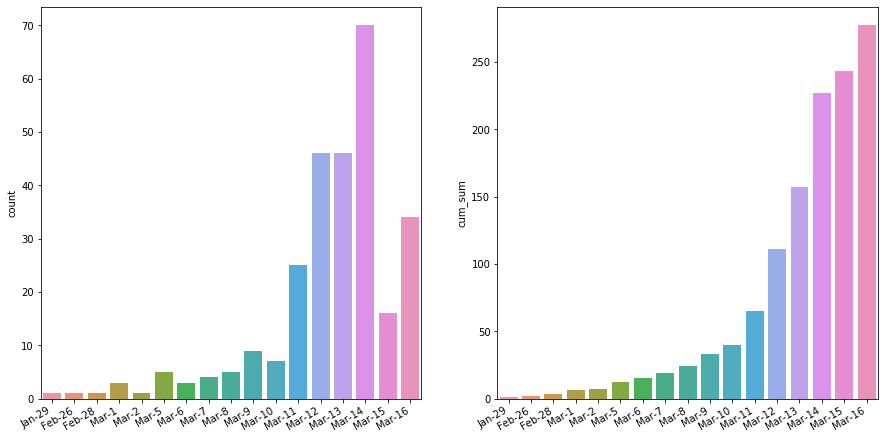

In [12]:
covid = dmc.extract_counts(df)

#covid['cum_sum'] = covid['count'].cumsum()
print(covid)
print(covid.dtypes)

date_mapping = ["{}-{}".format(x.strftime("%b"),x.day) for x in covid['new_dates']]
print(date_mapping)
fig,axes = plt.subplots(1,2,figsize=(15,8))
sns.barplot(x=date_mapping, y='count', data=covid,ax=axes[0])
sns.barplot(x=date_mapping, y='cum_sum', data=covid,ax=axes[1])

fig.autofmt_xdate()

